# Horizon

The notebook will investigate the `viewf.horizon.horizon` function and compare with the IPW version.

The test for horizon is slightly different than standard unittests. This is because we're comparing the IPW version of horizon to the python version. The main difficulty is the bit resolution of the IPW images takes the double resolution values, converts them to an integer for storage then converts them back to floats. The tests have tried to mimic this behaviour and most of the horizon values are extremely close.

Because of the differences in bit resolution and potential differences caused by operating systems, the tests are testing that the values are close since they are not expected to be equal. There are values that are larger than the tollerance but should be less than 6 pixels for the 26,208 pixels in the test domain.

Therefore the tests check that the new python horizon values are close and that any large difference are still small.


In [1]:
import numpy as np
from spatialnc import ipw
import matplotlib.pyplot as plt

from viewf.horizon import horizon

In [2]:
class TestHorizon():
    
    int_min = 0
    int_max = 2**16-1   # 16 bit images

    def __init__(self, azimuth):

        self.azimuth = azimuth
        
        # input DEM
        infile = '../tests/Lakes/gold_ipw/gold_dem.ipw'
        d = ipw.IPW(infile)

        # C code for hor1d is expecting double
        # the LQ headers have added some small values in the linearization of the image
        self.gold_dem = np.double(d.bands[0].data)
        self.spacing = d.bands[0].dline
        
        # Horizon gold files
        self.gold_file = '../tests/Lakes/gold_ipw/horizon/horizon_{}.ipw'.format(azimuth)
        gold = ipw.IPW(self.gold_file)
        self.gold_data = gold.bands[0].data

        # to make a fair comparison, first convert the hcos to
        # integers then back using the 16 bit LQ
        # with horizon the float min/max are constant from 0-1
        self.float_min = 1.0
        self.float_max = 0.0   
        
        self.run_horizon()
        
    def int_to_float(self, x):
        return (self.float_max - self.float_min) * \
            (x / self.int_max) + self.float_min

    def run_horizon(self):
        """Run the horizon function for a given azimuth and
        compare with the gold file
        """

        self.hcos = horizon(self.azimuth, self.gold_dem, self.spacing)

        # convert the numpy array from a float, to int and back
        self.h_int = ipw.map_fn(self.hcos, self.float_min,
                           self.float_max, self.int_min, self.int_max)
        self.h_float = self.int_to_float(self.h_int)
        
    def plot(self):
        d = self.gold_data - self.h_float
#         d = self.int_data - self.h_int

        fig, ax = plt.subplots(2, 2, figsize = (15, 15))
        fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
        fig.suptitle('{} degrees'.format(self.azimuth))

        # IPW original
        im0 = ax[0, 0].imshow(self.gold_data)
        ax[0, 0].set_title('IPW output')
        fig.colorbar(im0, ax=ax[0, 0])

        # horizon output
        im1 = ax[0, 1].imshow(self.h_float)
        ax[0, 1].set_title('horizon output')
        fig.colorbar(im1, ax=ax[0, 1])

        # difference
        var_lim = max([abs(d.min()), abs(d.max())])
        var_lim = 1e-4
        im2 = ax[1, 0].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
        ax[1, 0].set_title('Difference, gold - new')
        fig.colorbar(im2, ax=ax[1, 0])

        ax[1, 1].hist(d, bins=30)
        ax[1, 1].set_title('Histogram')

        # remove the x and y ticks
        for a in ax.flatten()[:3]:
            a.set_xticks([])
            a.set_yticks([])

        plt.show()

        

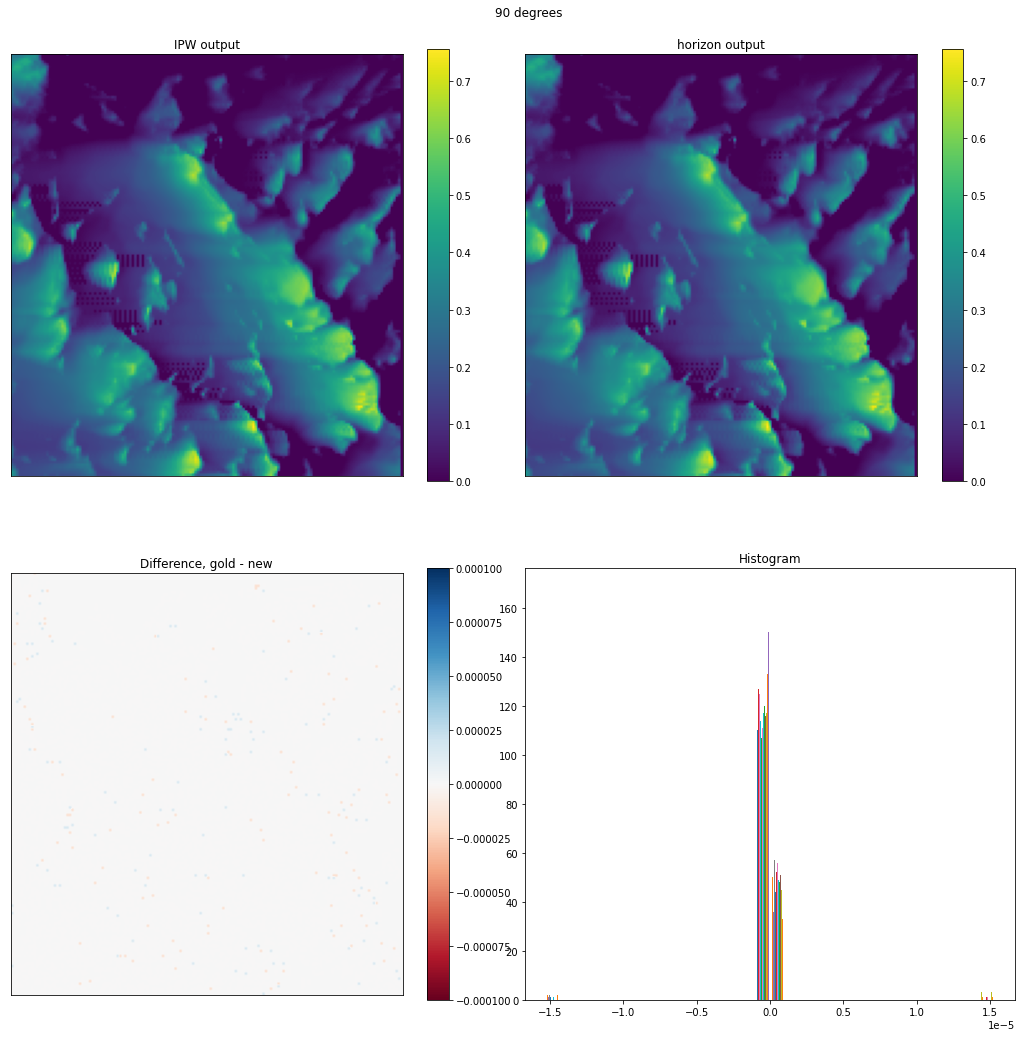

In [3]:
# East or 90 degrees
h = TestHorizon(90)
np.testing.assert_allclose(h.h_float, h.gold_data, rtol=1e-07, atol=1e-4)
h.plot()

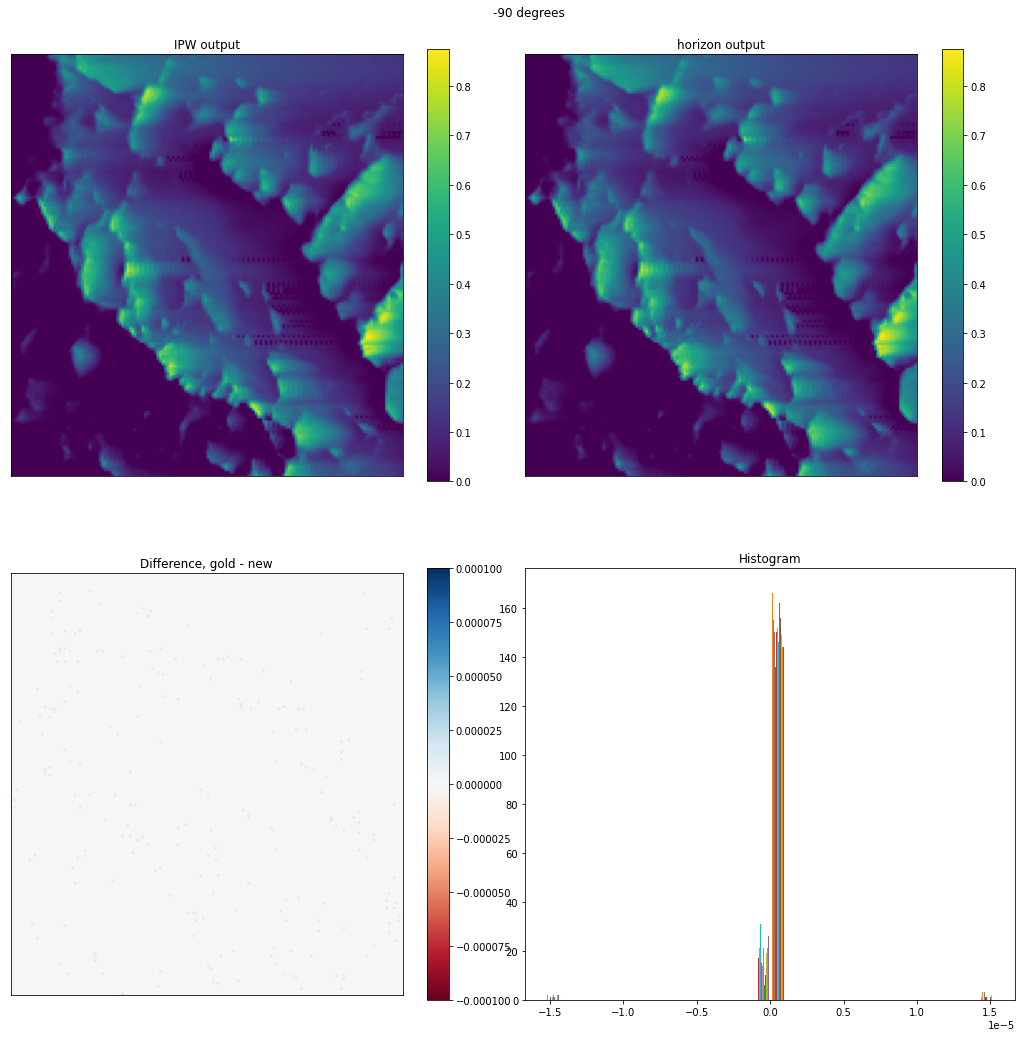

In [4]:
# West or -90 degrees
h = TestHorizon(-90)
np.testing.assert_allclose(h.h_float, h.gold_data, rtol=1e-07, atol=1e-4)
h.plot()

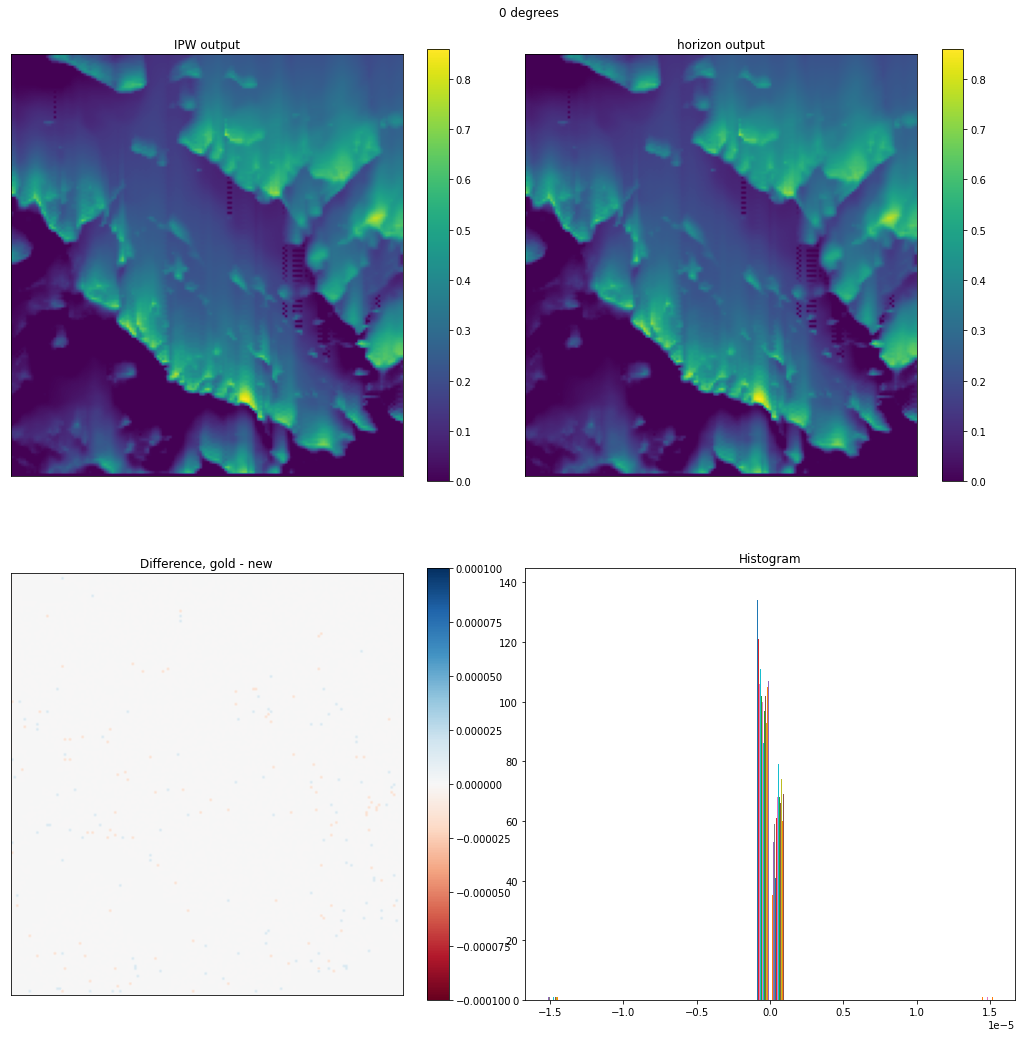

In [5]:
# South or 0 degrees
h = TestHorizon(0)
np.testing.assert_allclose(h.h_float, h.gold_data, rtol=1e-07, atol=1e-4)
h.plot()

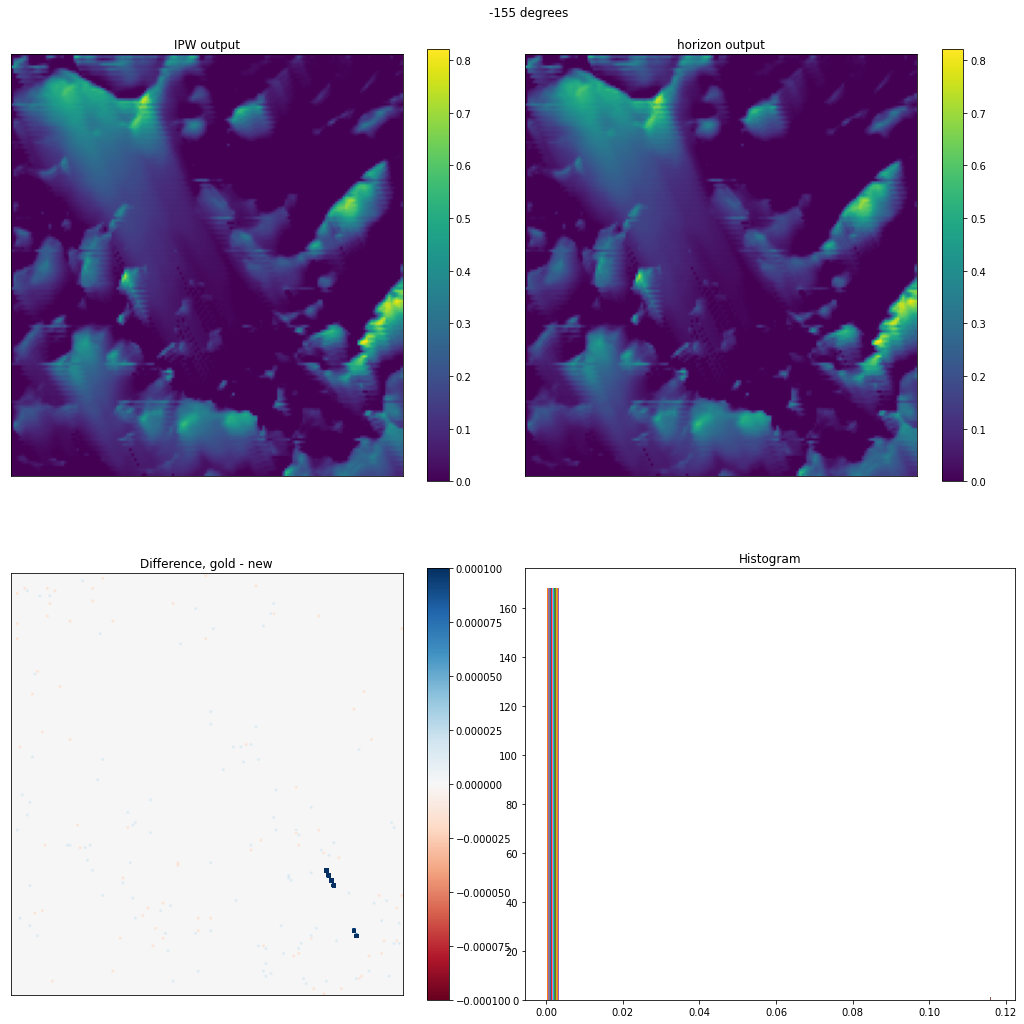

In [6]:
# -155 degrees, the one that has most error with IPW images
h = TestHorizon(-155)
h.plot()

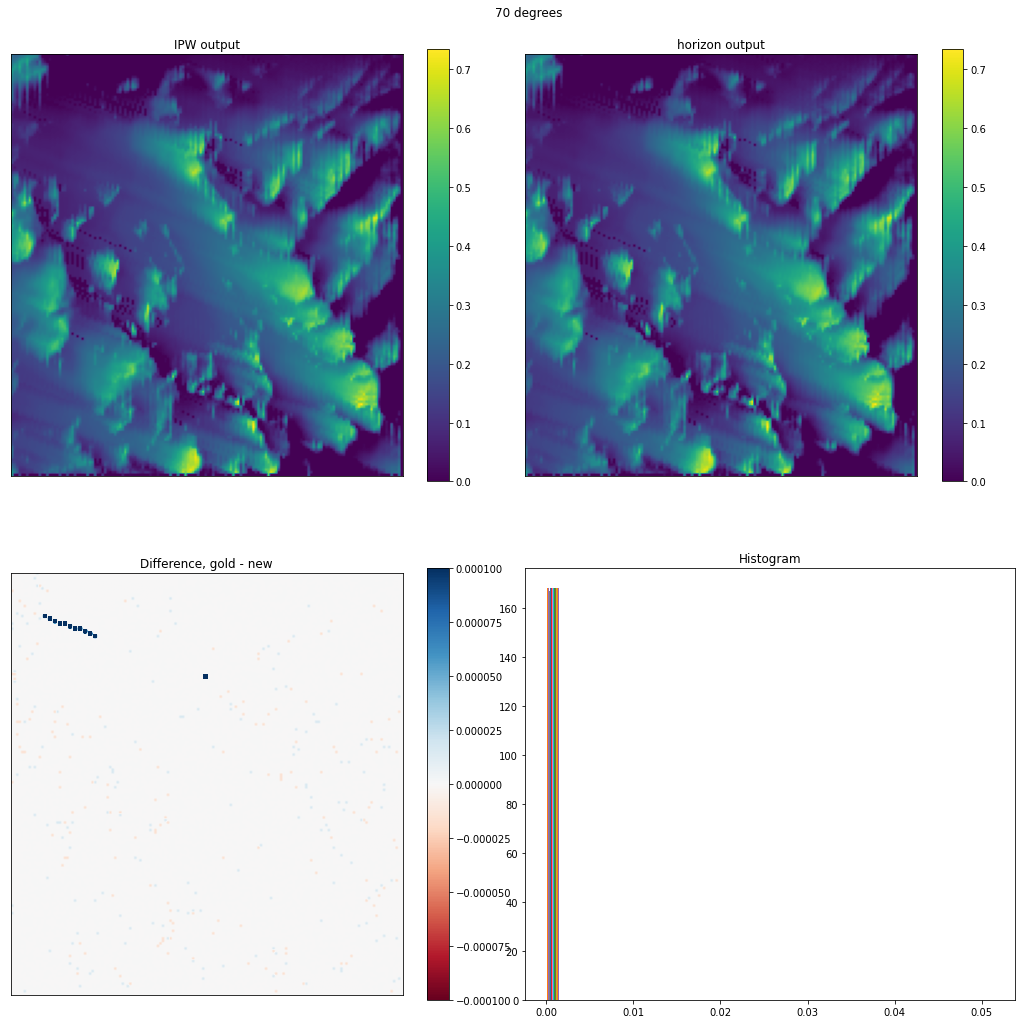

In [7]:
# 70 degrees, the one that has most error with IPW images
h = TestHorizon(70)
h.plot()